In [1]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation,Bidirectional,Dropout
from keras.layers.recurrent import SimpleRNN,LSTM,GRU
from keras.layers import Embedding,Flatten,Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

# 读取数据

In [2]:
imdb_dir = r"D:\\USTC\\深度学习\\Lab2\\data\\imdb\\aclImdb"
train_dir = os.path.join(imdb_dir,"train")

labels = []
texts = []

for label_type in ["neg","pos"]:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            with open(os.path.join(dir_name,fname),encoding='UTF-8') as f:
                texts.append(f.read())
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)           

# 设定参数并划分数据集

In [3]:
maxlen = 200
training_samples = 20000
validation_samples = 5000
max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
print(len(sequences))
word_index = tokenizer.word_index
print(len(word_index))

25000
88582


In [4]:
data = sequence.pad_sequences(sequences,maxlen=maxlen)
labels = np.asarray(labels)
print(data.shape)
print(labels.shape)
indices = np.arange(0,data.shape[0])
np.random.shuffle(indices)
print(labels.shape)

(25000, 200)
(25000,)
(25000,)


In [5]:
data = data[indices ]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(20000, 200)
(20000,)
(5000, 200)
(5000,)


# GloVe

In [6]:

glove_dir = r"D:\\USTC\\深度学习\\Lab2\\vector_cache"
embeddings_index = {}
f = open(os.path.join(glove_dir,"glove.6B.100d.txt"),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype="float32")
    embeddings_index[word] = coefs
f.close()
print(len(embeddings_index))

400000


In [7]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 模型设置

In [8]:
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(SimpleRNN(128))
model.add(Dropout(0.1))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [9]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# 优化器与loss函数

In [10]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["acc"]
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          500000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [11]:
ES=EarlyStopping(monitor='val_acc',patience=5)
filepath='best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0,save_best_only=True,mode='max')
callbacks_list = [checkpoint]

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, mode='auto')

In [13]:
history = model.fit(x_train,y_train,epochs=40,batch_size=256,validation_data=(x_val,y_val),callbacks=[ES,callbacks_list,reduce_lr])
model.save_weights("glove_model.h5")

Epoch 1/40
79/79 [==============================] - 18s 204ms/step - loss: 0.6625 - acc: 0.5947 - val_loss: 0.6331 - val_acc: 0.6534 - lr: 0.0010
Epoch 2/40
79/79 [==============================] - 16s 199ms/step - loss: 0.6124 - acc: 0.6711 - val_loss: 0.5685 - val_acc: 0.7152 - lr: 0.0010
Epoch 3/40
79/79 [==============================] - 15s 196ms/step - loss: 0.6059 - acc: 0.6707 - val_loss: 0.5753 - val_acc: 0.6998 - lr: 0.0010
Epoch 4/40
79/79 [==============================] - 15s 195ms/step - loss: 0.5780 - acc: 0.6960 - val_loss: 0.5687 - val_acc: 0.7116 - lr: 0.0010
Epoch 5/40
79/79 [==============================] - 15s 196ms/step - loss: 0.5638 - acc: 0.7096 - val_loss: 0.5408 - val_acc: 0.7414 - lr: 0.0010
Epoch 6/40
79/79 [==============================] - 16s 197ms/step - loss: 0.5269 - acc: 0.7423 - val_loss: 0.5703 - val_acc: 0.7024 - lr: 0.0010
Epoch 7/40
79/79 [==============================] - 16s 198ms/step - loss: 0.6048 - acc: 0.6493 - val_loss: 0.6446 - val_acc

# 处理测试集

In [14]:
test_dir = os.path.join(imdb_dir,"test")

labels = []
texts = []

for label_type in ["neg","pos"]:
    dir_name = os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            with open(os.path.join(dir_name,fname),encoding='UTF-8') as f:
                texts.append(f.read())
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)     

In [15]:
sequences = tokenizer.texts_to_sequences(texts)
print(len(sequences))
word_index = tokenizer.word_index
print(len(word_index))

25000
88582


In [16]:
data = sequence.pad_sequences(sequences,maxlen=maxlen)
labels = np.asarray(labels)
print(data.shape)
print(labels.shape)
indices = np.arange(0,data.shape[0])
np.random.shuffle(indices)
print(labels.shape)

(25000, 200)
(25000,)
(25000,)


In [17]:
data = data[indices]
labels = labels[indices]
x_test = data
y_test = labels
print(x_test.shape)
print(y_test.shape)

(25000, 200)
(25000,)


In [18]:
model.evaluate(x_test,y_test)

782/782 [==============================] - 26s 33ms/step - loss: 0.5589 - acc: 0.7118


[0.55890291929245, 0.7118399739265442]

# 使用最佳参数预测

In [19]:
model.load_weights('best.hdf5')
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
model.evaluate(x_test,y_test)

782/782 [==============================] - 26s 32ms/step - loss: 0.5425 - accuracy: 0.7394


[0.5424620509147644, 0.739359974861145]

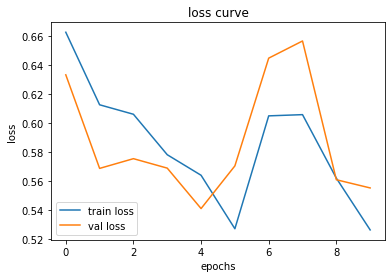

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss curve')
plt.legend()
plt.show()